# A Minimal 2‑D Helmholtz + GMRES Walkthrough (Julia)

In this notebook I build a small 2‑D Helmholtz solver and run plain GMRES.
The goal is **not** ultimate performance; I want a clear baseline that shows
what the residuals look like and how frequency and right‑hand sides affect convergence.

What I do:
1. Discretise \( (-\Delta - \omega^2 m)u=f \) on \([0,1]^2\) with a 5‑point stencil (Dirichlet on the boundary).
2. Assemble the sparse matrix \(A\) and a few right‑hand sides \(f\).
3. Validate on a small grid with a **direct** sparse solve.
4. Run **basic GMRES (no restart)** and log residual norms and residual *fields*.
5. Compare different \(f\) and sweep over \(\omega\).

## 0) Packages

In [1]:
import Pkg
try
    @eval using Plots
catch
    Pkg.add("Plots"); @eval using Plots
end
using LinearAlgebra, SparseArrays, Random
default(grid=false)    # cleaner figures

println("Julia ", VERSION, " — packages ready.")

Julia 1.11.5 — packages ready.


## 1) Problem setup

PDE: \( (-\Delta - \omega^2 m)u = f \) on \([0,1]^2\) with **Dirichlet** \(u=0\) on the boundary.
I start with a constant medium \(m=1\). The grid has \(N\times N\) interior nodes (spacing \(h=1/(N+1)\)).

In [2]:
N_base = 100        # interior points per direction
ω_base = 25.0        # frequency
m_base = 1.0         # constant m
println(("Grid: %dx%d,  ω = %.1f,  m = %.1f") % (N_base, N_base, ω_base, m_base))

MethodError: MethodError: no method matching rem(::String, ::Tuple{Int64, Int64, Float64, Float64})
The function `rem` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  rem(::Any, ::Any, !Matched::RoundingMode{:FromZero})
   @ Base div.jl:105
  rem(::Any, ::Any, !Matched::RoundingMode{:Nearest})
   @ Base div.jl:102
  rem(::Any, ::Any, !Matched::RoundingMode{:Up})
   @ Base div.jl:101
  ...


## 2) Discretisation (5‑point Laplacian + mass)

For each interior node \((i,j)\) the 5‑point Laplacian gives
\[
\tfrac{1}{h^2}(-u_{i-1,j}-u_{i+1,j}-u_{i,j-1}-u_{i,j+1}+4u_{i,j}).
\]
I build \(A = (-\Delta_h) - \omega^2 m I\) directly on the interior grid (Dirichlet means the boundary values are zero and
do not appear as unknowns).

In [3]:
function helmholtz_matrix_2d(N::Int, ω::Float64; m::Float64=1.0)
    h = 1.0/(N+1)
    main = fill(2.0, N); off = fill(-1.0, N-1)
    L1 = spdiagm(-1 => off, 0 => main, 1 => off) / h^2
    I  = spdiagm(0 => ones(N))
    Lap = kron(I, L1) + kron(L1, I)      # -Δ_h
    A = Lap - (ω^2*m) * spdiagm(0 => ones(N*N))
    return A
end

A_base = helmholtz_matrix_2d(N_base, ω_base; m=m_base)
println("A size: ", size(A_base), "   nnz = ", nnz(A_base))

A size: (10000, 10000)   nnz = 49600


## 3) Right‑hand sides and light plotting helpers

In [4]:
function rhs_point(N::Int; center=(0.5,0.5), σ=0.03)
    h = 1.0/(N+1); xs = collect(1:N).*h
    X = repeat(xs, 1, N); Y = repeat(xs', N, 1)
    f = @. exp(-((X-center[1])^2 + (Y-center[2])^2)/(2σ^2))
    return vec(f)
end
function rhs_plane(N::Int; kx=4π, ky=0.0)
    h = 1.0/(N+1); xs = collect(1:N).*h
    X = repeat(xs, 1, N); Y = repeat(xs', N, 1)
    f = @. sin(kx*X + ky*Y); return vec(f)
end
function rhs_random(N::Int; seed=1)
    rng = MersenneTwister(seed); return randn(rng, N*N)
end

# small helpers for consistent figures
function show_field(u::AbstractMatrix; ttl::AbstractString="")
    xs = collect(1:size(u,1))./(size(u,1)+1)
    heatmap(xs, xs, u; aspect_ratio=1, colorbar=true, title=ttl, xlabel="x", ylabel="y")
end
function show_residual_curve(hist::Vector{Float64}; ttl::AbstractString="GMRES residual (relative)")
    rel = hist ./ hist[1]; its = 0:length(rel)-1
    plot(its, rel; yscale=:log10, xlabel="iteration", ylabel="‖r_k‖ / ‖r_0‖",
         marker=:circle, title=ttl)
end

println("RHS + plotting helpers defined.")

RHS + plotting helpers defined.


## 4) Direct solve on a small grid (check)

For a small grid I use the sparse direct solver \(A\backslash b\) to make sure the discretisation behaves as expected.

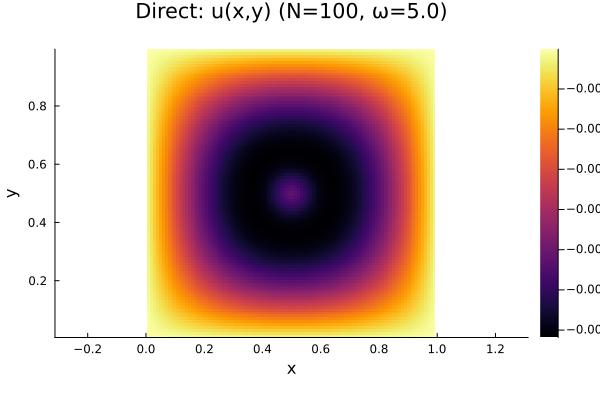

  0.172521 seconds (40.16 k allocations: 26.350 MiB, 60.97% compilation time)
  0.069701 seconds (167 allocations: 23.895 MiB, 18.01% gc time)
  0.062236 seconds (166 allocations: 23.895 MiB, 12.55% gc time)
  0.040539 seconds (162 allocations: 23.895 MiB, 1.55% gc time)


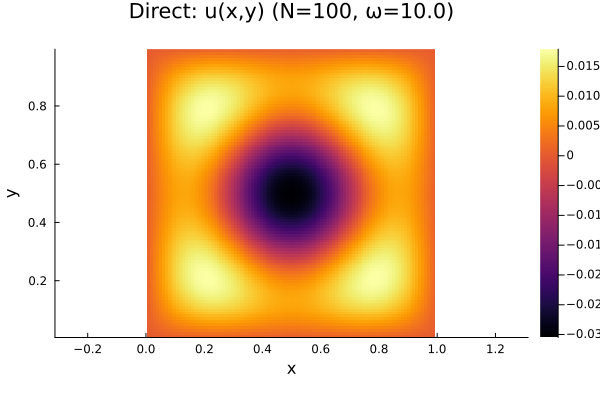

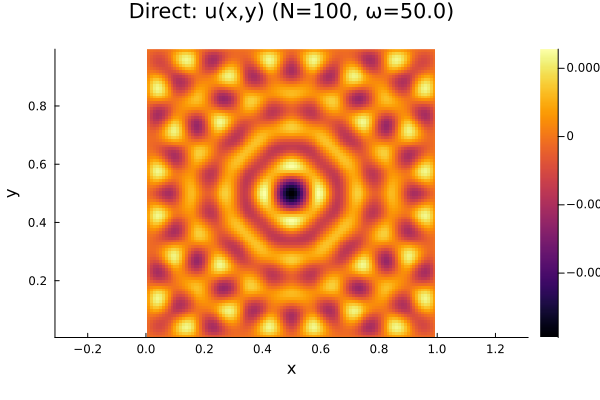

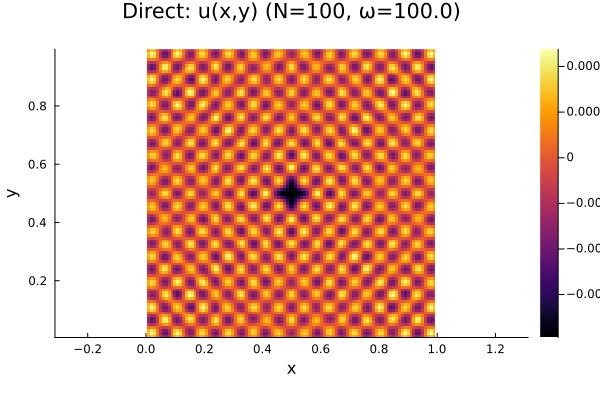

In [5]:
w_range = [5.0, 10.0, 50.0, 100.0]
N_small = 100

for ω_small in w_range
    A_small = helmholtz_matrix_2d(N_small, ω_small; m = 1.0)
    b_small = rhs_point(N_small)
    @time x_small = A_small \ b_small
    display(
        show_field(
            reshape(x_small, N_small, N_small);
            ttl = "Direct: u(x,y) (N=$N_small, ω=$ω_small)"
        )
    )
end


  0.012758 seconds (160 allocations: 5.519 MiB)
  0.012263 seconds (159 allocations: 5.500 MiB)
  0.011080 seconds (159 allocations: 5.500 MiB)
  0.011881 seconds (159 allocations: 5.500 MiB)


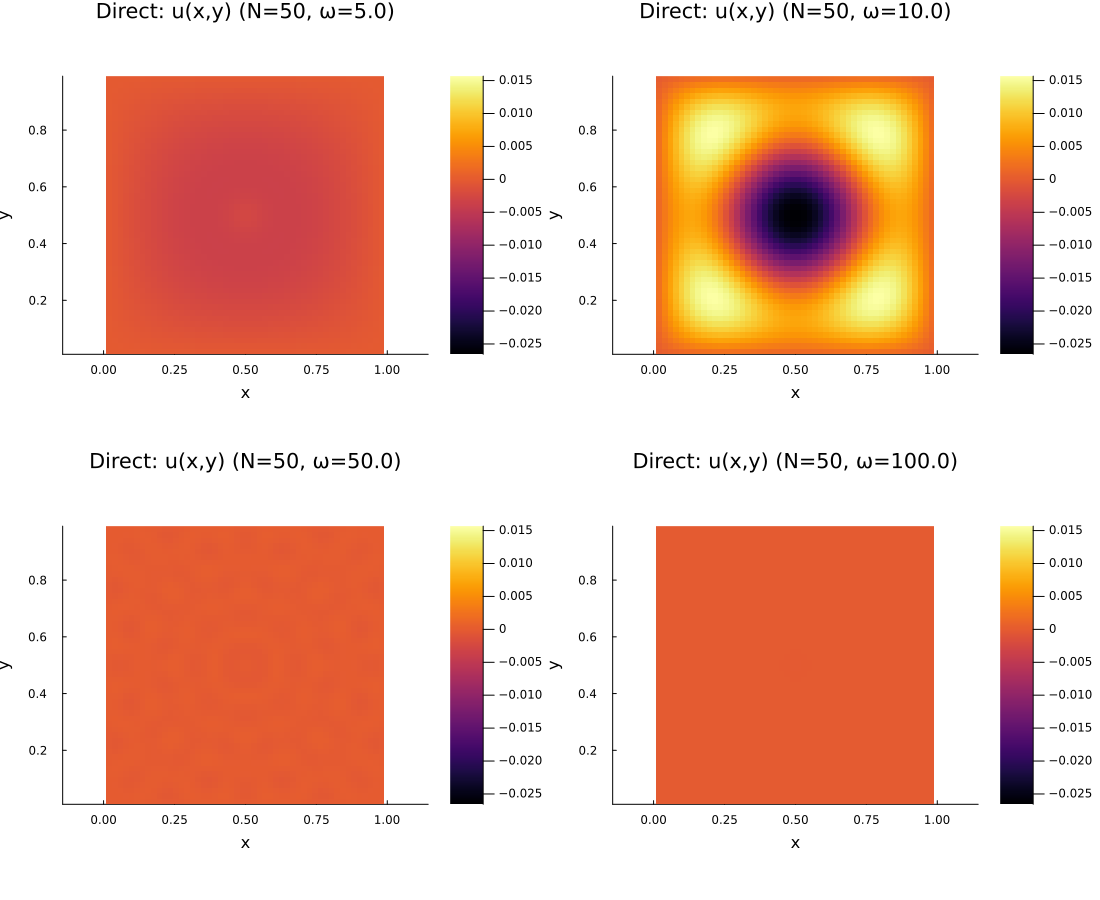

In [6]:
using LinearAlgebra, SparseArrays, Plots

# --- Problem setup
N = 50
omegas = [5.0, 10.0, 50.0, 100.0]

# Use the same RHS for all runs (Gaussian point source)
b = rhs_point(N)              # already returns a vector length N^2
h = 1 / (N + 1)
xs = collect(1:N) .* h        # grid coordinates for plotting

# --- Solve for each ω with a direct sparse solve
fields = Matrix{Float64}[]    # will store N×N solutions for plotting
for ω in omegas
    A = helmholtz_matrix_2d(N, ω; m=1.0)
    @time x = A \ b
    push!(fields, reshape(x, N, N))
end

# --- Shared color limits so plots are comparable
vmin = minimum(minimum.(fields))
vmax = maximum(maximum.(fields))

# --- Make 2×2 panel of heatmaps
plots = [heatmap(xs, xs, fields[i];
    aspect_ratio = 1,
    xlabel = "x", ylabel = "y",
    title = "Direct: u(x,y) (N=$(N), ω=$(omegas[i]))",
    clims = (vmin, vmax), colorbar = true) for i in eachindex(omegas)]
plot(plots..., layout = (2, 2), size = (1100, 900))



## 5) Basic GMRES 
I implement the textbook version of GMRES. It stores (i) the residual norm per iteration and
(ii) full residual vectors (to visualise spatial structure).

In [7]:
function gmres_basic(A::SparseMatrixCSC{Float64,Int}, b::Vector{Float64};
                      x0=zeros(size(A,1)), maxit::Int=60, tol::Float64=1e-8)
    n = size(A,1); x = copy(x0)
    r0 = b - A*x; β = norm(r0)
    if β == 0.0; return x, [0.0], Vector{Vector{Float64}}(); end
    V = zeros(Float64, n, maxit+1); H = zeros(Float64, maxit+1, maxit)
    res_hist = Float64[β]; res_fields = Vector{Vector{Float64}}()
    V[:,1] = r0/β
    for k in 1:maxit
        w = A*V[:,k]
        for j in 1:k
            H[j,k] = dot(V[:,j], w); w .-= H[j,k]*V[:,j]
        end
        H[k+1,k] = norm(w)
        if H[k+1,k] > 0 && k < maxit; V[:,k+1] .= w/H[k+1,k]; end
        e1 = zeros(Float64, k+1); e1[1] = β
        y = H[1:k+1,1:k] \ e1
        x = x0 + V[:,1:k]*y
        rk = b - A*x
        push!(res_fields, copy(rk))
        rnorm = norm(rk); push!(res_hist, rnorm)
        if rnorm < tol; break; end
    end
    return x, res_hist, res_fields
end

println("GMRES ready.")

GMRES ready.


## 6) Baseline run (point source)

Run GMRES for \(N=100\), \(\omega=25\), point source. Show the solution, the residual history (relative),
and a few residual snapshots to expose the spatial structure that GMRES struggles with.

Running GMRES for ω = 5.0 ...
  0.664326 seconds (19.76 k allocations: 604.358 MiB, 51.78% gc time)
Running GMRES for ω = 100.0 ...
  0.367130 seconds (19.76 k allocations: 604.351 MiB, 30.02% gc time)


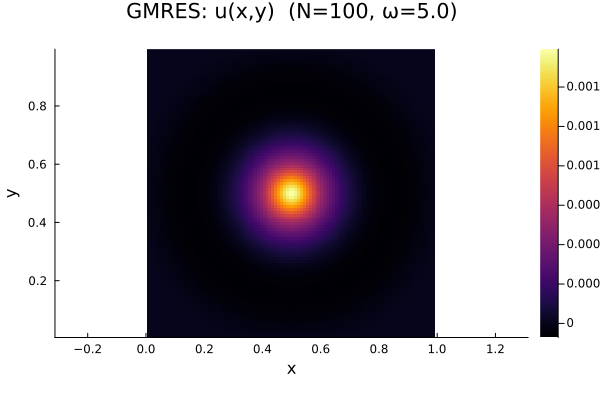

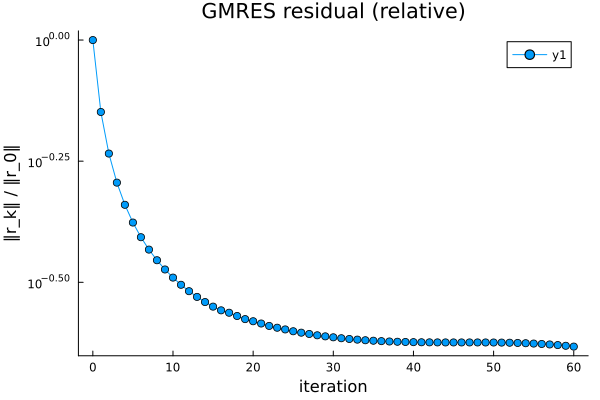

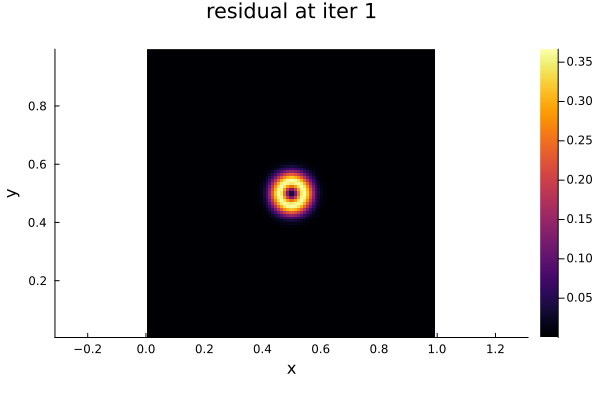

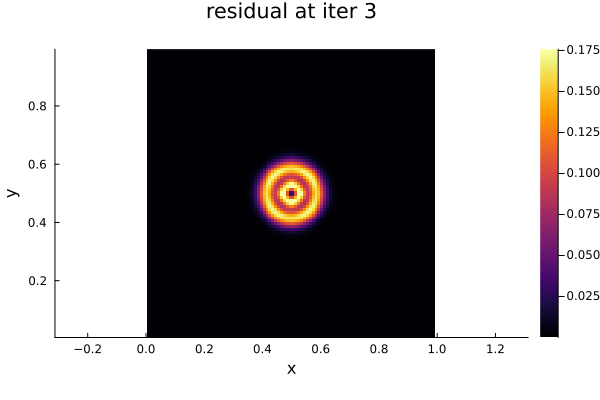

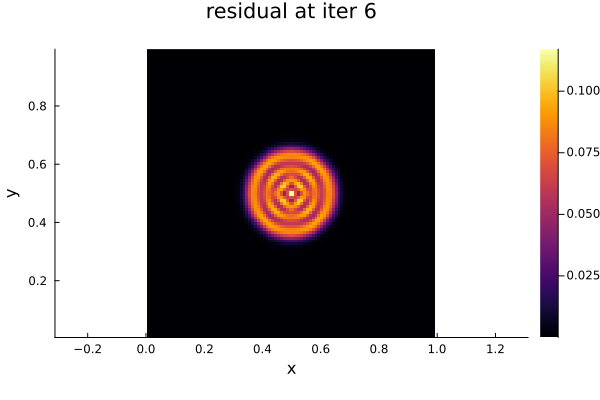

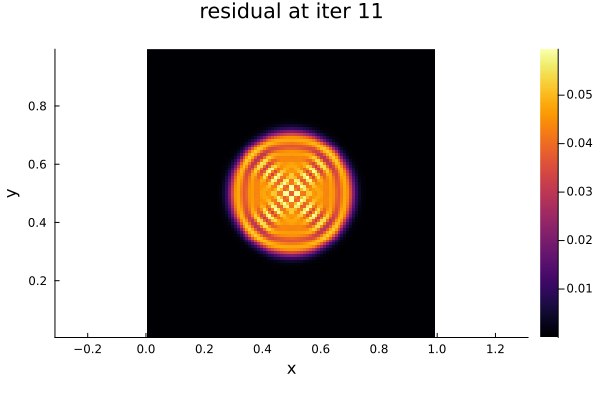

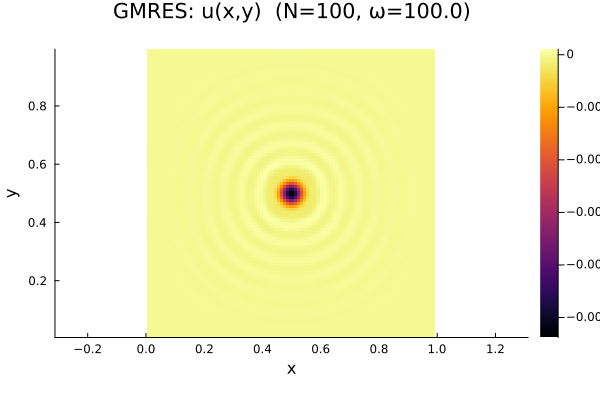

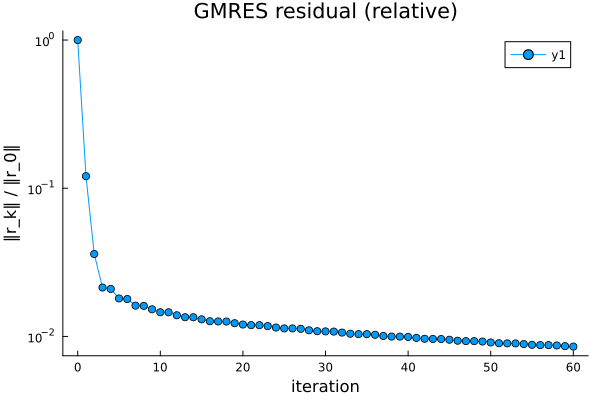

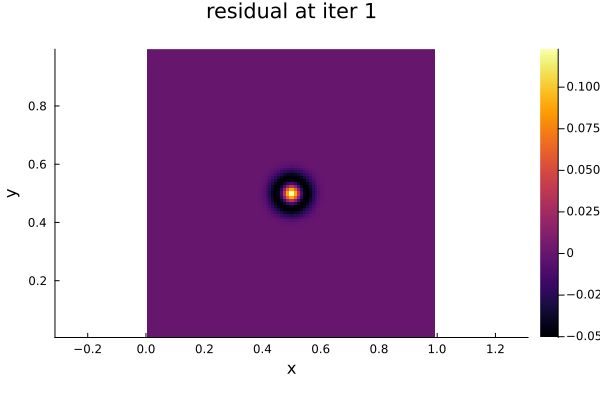

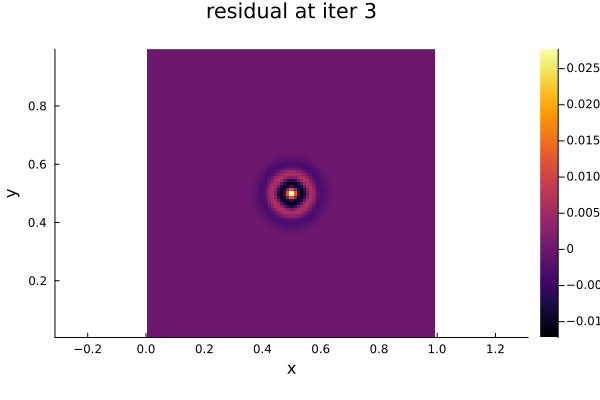

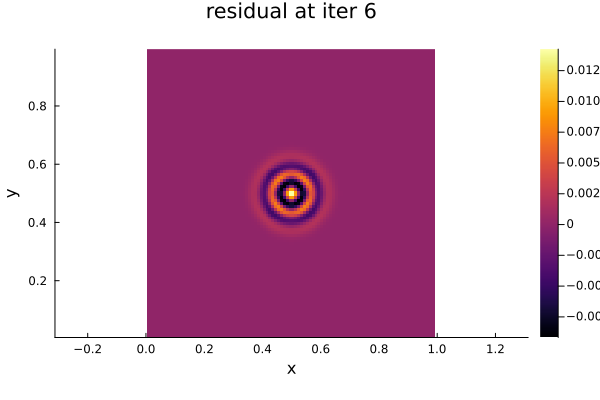

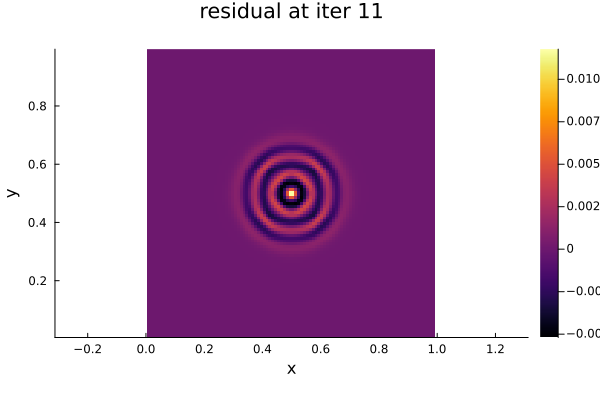

In [8]:
w_lowbase= 5.0
w_highbase= 100.0

for ω_base in (w_lowbase, w_highbase)
    println("Running GMRES for ω = $ω_base ...")

    A0 = helmholtz_matrix_2d(N_base, ω_base; m=m_base)
    b0 = rhs_point(N_base)
    @time x_gm, hist_gm, rlist_gm = gmres_basic(A0, b0; maxit=60, tol=1e-8)

    display( show_field(reshape(x_gm, N_base, N_base); ttl="GMRES: u(x,y)  (N=$N_base, ω=$ω_base)") )
    display( show_residual_curve(hist_gm) )

    for kview in (1, 3, 6, min(11, length(rlist_gm)))
        1 <= kview <= length(rlist_gm) || continue
        display( show_field(reshape(rlist_gm[kview], N_base, N_base);
                            ttl="residual at iter $(kview)") )
    end
end

## 7) Changing the right‑hand side

I rerun GMRES for a plane wave and a random load to see how the solution and the residual curve change.

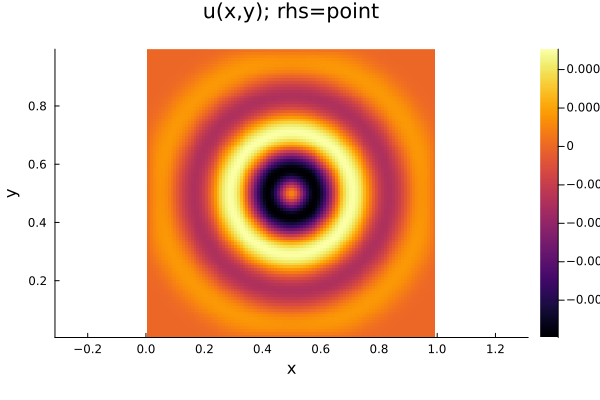

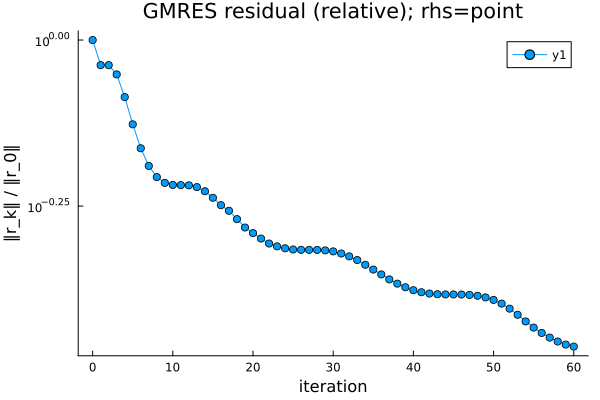

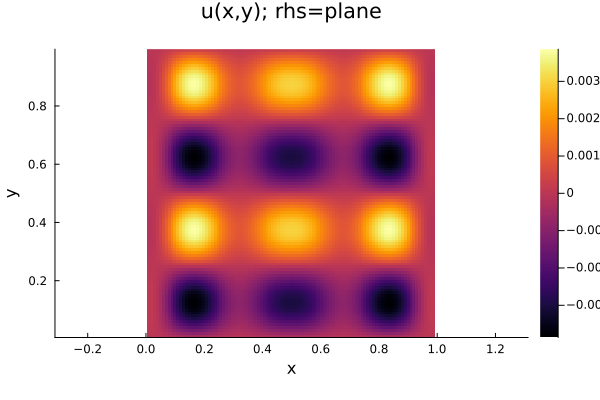

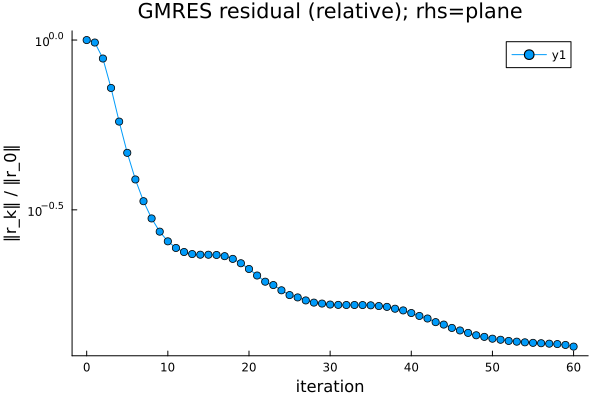

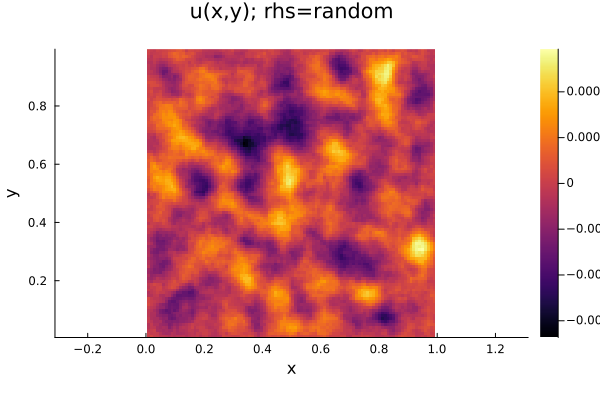

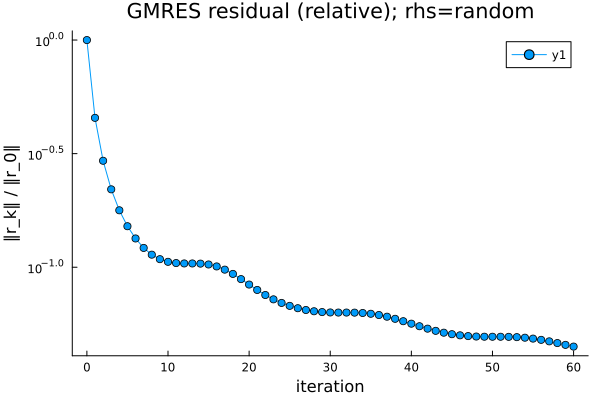

In [9]:
for label in ("point","plane","random")
    A_t = helmholtz_matrix_2d(N_base, ω_base; m=1.0)
    b_t = label=="point" ? rhs_point(N_base) : label=="plane" ? rhs_plane(N_base) : rhs_random(N_base)
    x_t, h_t, _ = gmres_basic(A_t, b_t; maxit=60, tol=1e-8)
    display( show_field(reshape(x_t, N_base, N_base); ttl="u(x,y); rhs=$(label)") )
    display( show_residual_curve(h_t; ttl="GMRES residual (relative); rhs=$(label)") )
end

## 8) Frequencies compared

Higher \(\omega\) (shorter wavelengths) typically makes Helmholtz harder. I sweep a few values and plot the
relative residual histories together.

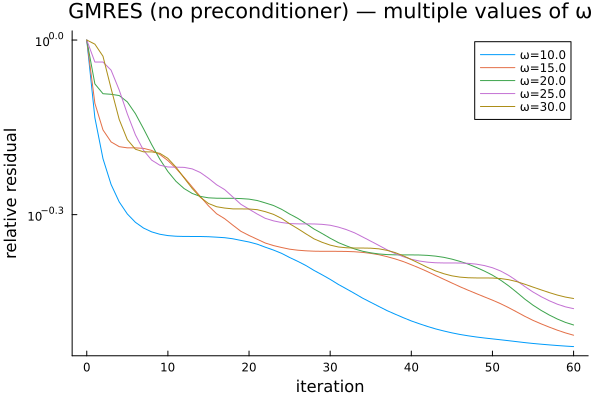

In [10]:
ω_list = [10.0, 15.0, 20.0, 25.0, 30.0]
curves = Vector{Vector{Float64}}()
for ω in ω_list
    A_s = helmholtz_matrix_2d(N_base, ω; m=1.0); b_s = rhs_point(N_base)
    _, h_s, _ = gmres_basic(A_s, b_s; maxit=60, tol=1e-8)
    push!(curves, h_s ./ h_s[1])
end

p = plot(title="GMRES (no preconditioner) — multiple values of ω",
         xlabel="iteration", ylabel="relative residual", yscale=:log10)
for (i, relc) in enumerate(curves)
    its = 0:length(relc)-1
    plot!(p, its, relc, label="ω=$(ω_list[i])")
end
display(p)

## 9) Quick validation vs direct solve (small grid)

For a small grid I compare GMRES to the sparse direct solution and report the relative error.

In [11]:
N_val, ω_val = 60, 15.0
A_v = helmholtz_matrix_2d(N_val, ω_val; m=1.0); b_v = rhs_point(N_val)
x_gm_v, h_v, _ = gmres_basic(A_v, b_v; maxit=60, tol=1e-8)
x_dir_v = A_v \ b_v
rel_err = norm(x_dir_v - x_gm_v) / norm(x_dir_v)
println(("Relative error (GMRES vs direct) at N=%d, ω=%.1f: %.3e") % (N_val, ω_val, rel_err))
display( show_field(reshape(x_dir_v, N_val, N_val); ttl="Direct u(x,y) (validation)") )
display( show_residual_curve(h_v; ttl="GMRES residual (validation case)") )

MethodError: MethodError: no method matching rem(::String, ::Tuple{Int64, Float64, Float64})
The function `rem` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  rem(::Any, ::Any, !Matched::RoundingMode{:FromZero})
   @ Base div.jl:105
  rem(::Any, ::Any, !Matched::RoundingMode{:Nearest})
   @ Base div.jl:102
  rem(::Any, ::Any, !Matched::RoundingMode{:Up})
   @ Base div.jl:101
  ...


### Notes

- Everything here is intentionally bare‑bones to make the behaviour visible.
- Next logical steps (not included here): add a simple left preconditioner (Jacobi/ILU),
  try a two‑grid V‑cycle as \(M^{-1}\), and/or use a lower‑frequency solve as an
  initial guess or preconditioner (frequency‑transfer idea).